In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, learning_curve, StratifiedKFold
from pprint import pprint
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV    
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=ConvergenceWarning)


In [3]:
# Loading data into dataframes
def data_preprocessing(file_name):
    df = pd.read_csv(file_name)
    df.reset_index(drop=True)
    df = df.drop(df.columns[0], axis=1)
    return df

word_embed_train = data_preprocessing('384EMBEDDINGS_TRAIN.csv')
word_embed_test = data_preprocessing('384EMBEDDINGS_TEST.csv')
word_embed_validation = data_preprocessing('384EMBEDDINGS_VALIDATION.csv')

tfidf_train = data_preprocessing('TFIDF_TRAIN.csv')
tfidf_test = data_preprocessing('TFIDF_TEST.csv')
tfidf_validation = data_preprocessing('TFIDF_VALIDATION.csv')

train_data = data_preprocessing('TRAIN.csv')
test_data = data_preprocessing('TEST_NO_LABELS.csv')
validation_data = data_preprocessing('VALIDATION.csv')

In [4]:
# Setting up Train and Test dataset

y_train = train_data['rating'] # Train labels
y_vad = validation_data['rating'] # Validation labels
X_train = train_data.drop('rating', axis=1)
X_vad = validation_data.drop('rating', axis=1)

X_train_embed = word_embed_train # Train features for word embedding
X_vad_embed = word_embed_validation #Validate features

X_train_tf = tfidf_train # Train features for tfidf
X_vad_tf = tfidf_validation # Validate features

X_train_all = pd.concat([word_embed_train, tfidf_train], axis=1)
X_vad_all = pd.concat([word_embed_validation, tfidf_validation],axis=1)
X_test_all = pd.concat([word_embed_test, tfidf_test], axis=1)


In [5]:
# Evaluation
# Get scores for the model
def get_scores(pred_label, true_label, average='macro'):
    # Accuracy
    accuracy = metrics.accuracy_score(true_label, pred_label)
    # Precision, Recall and F1-score (default: macro average)
    score_report = metrics.precision_recall_fscore_support(true_label, pred_label, average=average, zero_division=0) 
    # Confusion Matrix 
    confusion = metrics.confusion_matrix(true_label, pred_label)       
    return accuracy, score_report, confusion 

def plot_cm(plot_name,confusion):
    plt.figure(figsize=(4, 2))
    ax= plt.subplot()
    sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted ratings');ax.set_ylabel('True ratings'); 
    ax.set_title(plot_name); 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

def plot_learning_curve(plot_name, estimator, X_train, y_train, fold=5, scoring='f1_macro'):
    '''
    Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
    '''
    train_sizes, train_scores, valid_scores = learning_curve(estimator,X_train, 
                                                             y_train, scoring=scoring, cv=StratifiedKFold(fold),
                                                             train_sizes=np.linspace(0.1, 1.0, 5))
    print(f"Train scores: {np.round(np.mean(train_scores, axis=1),4)}")
    print(f"Validation scores: {np.round(np.mean(valid_scores, axis=1),4)}")
    plt.figure(figsize=(4, 3))
    plt.xlabel("training size")
    plt.ylabel("accuracy")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0,1.1,step=0.1))
    plt.grid(visible=True)
    plt.title(plot_name)
    plt.legend(loc="best")
    plt.show()

def display_performance(plot_name, pred_label, true_label):
    accuracy, scores, cm = get_scores(pred_label, true_label)
    print("Accuracy: ", round(accuracy,4))
    print("Precision: ", round(scores[0],4))
    print("Recall: ", round(scores[1],4))
    print("F1 : ", round(scores[2],4))
    plot_cm(plot_name, cm)

# Mismatched Reivew Examples
pd.set_option('display.max_colwidth', None)
def getMismatch(pred, sample_size):
    pred_df = pd.DataFrame(pred, columns=["prediction"])
    pred_df = pd.concat([validation_data, pred_df],axis=1)
    mismatched = pred_df.loc[pred_df["rating"] != pred_df["prediction"]]
    false_positive = mismatched.loc[mismatched["prediction"] == 1]
    false_negative = mismatched.loc[mismatched["prediction"] == -1]
    print("False Positive:")
    display(false_positive.head(sample_size))
    print("False Negative:")
    display(false_negative.head(sample_size))
    return false_positive, false_negative

In [8]:
def feature_searcher(estimator, X_train, y_train, param_grid, percentiles, fold=5):
    # Initialize variables to store the best score and corresponding best features and parameters
    best_score = 0
    best_features = None
    best_params = None
    best_perc = None
    total_iterations = len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(percentiles)  # 31 percentiles from 50 to 80
    # Iterate over all possible combinations of parameters for RandomForestClassifier
    with tqdm(total=total_iterations) as pbar:
        for params in ParameterGrid(param_grid):
            rf = RandomForestClassifier(**params, criterion='entropy',random_state=0)
            rf.fit(X_train, y_train)
            # Get feature importances and select features based on the provided percentile
            importances = rf.feature_importances_
            for p in percentiles:
                perc = np.percentile(importances, p)
                selected_features_name = X_train.columns[importances >= perc]
                X_train_selected = X_train[selected_features_name].copy()
                scores = cross_val_score(estimator, X_train_selected, y_train, cv=StratifiedKFold(fold), scoring='f1_macro')
                avg_score = np.mean(scores)
                pbar.update(1)
                # Update the best score, features, and parameters if the current score is better than the best score
                if avg_score > best_score:
                    best_score = avg_score
                    best_features = selected_features_name
                    best_params = params
                    best_perc = p
        print(f"Best Score: {best_score}")
        print(f"Best Features: {list(best_features)}")
        print(f"Best Percentile: {best_perc}")
        print(f"Best RandomForest Parameters: {best_params}")
    return best_features, best_score, best_perc, best_params

In [9]:
"""
    Train an MLP model and predict on the test data.
    
    Parameters:
    - X_train: Training data
    - y_train: Labels for training data
    - X_test: Test data to predict on
    - hidden_layers: Tuple indicating size of hidden layers. Default is (100,)
    - activation: Activation function for the hidden layers. Default is 'relu'
    - solver: The solver for weight optimization. Default is 'adam'
    - alpha: L2 penalty (regularization term) parameter.
    - random_state: Seed for the random number generator. Default is None
    
    Returns:
    - predictions: Predictions on the test data
    - mlp_classifier: The trained MLP model
"""
def mlp_model(X_train, X_vad, y_train):
   
    # Initialize MLP Classifier
    estimator = MLPClassifier(random_state=0)
    
    # Train the model
    mlp = estimator.fit(X_train, y_train)
    
    # Predict on test data
    pred = mlp.predict(X_vad)
    
    return pred, estimator




In [7]:
# Default MLPclassifier
mlp_embed_pred_base, mlp_embed_estimator_base = mlp_model(X_train_embed, X_vad_embed, y_train)


#RUNNING TIME 2minutes

In [22]:
pred_base = np.array(mlp_embed_pred_base)
np.savetxt("mlp_base_pred.txt", pred_base, fmt='%d')
# with open("mlp_base_pred.txt","w+") as f:
#     content = str(pred_base)
#     f.write

#### MLP Word Embeddings

Train scores: [0.9854 0.9821 0.9811 0.9816 0.9827]
Validation scores: [0.8768 0.8891 0.8932 0.8944 0.8952]


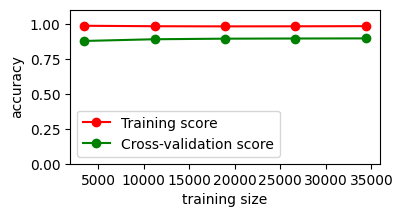

In [9]:
# Base model evaluation
plot_learning_curve(mlp_embed_estimator_base, X_train_embed, y_train) 

Accuracy:  0.9129
Precision:  0.8901
Recall:  0.8855
F1 :  0.8878


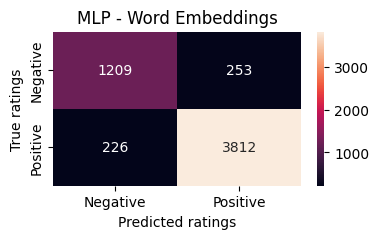

In [11]:
display_performance("MLP - Word Embeddings", mlp_embed_pred_base, y_vad)

#### MLP - TFIDF

Accuracy:  0.896
Precision:  0.8612
Recall:  0.8818
F1 :  0.8706


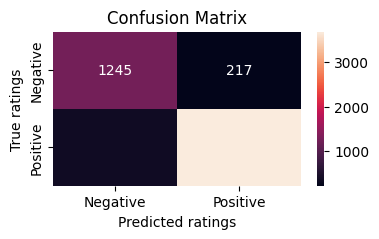

In [12]:
mlp_tf_pred, mlp_tf_estimator = mlp_model(X_train_tf, X_vad_tf, y_train)
display_performance(mlp_tf_pred, y_vad)

#### MLP - Both features

In [10]:
mlp_all_pred_base, mlp_all_estimator_base = mlp_model(X_train_all, X_vad_all, y_train)

In [26]:
mlp_all_pred_test, mlp_all_estimator_test = mlp_model(X_train_all,X_test_all , y_train)
mlp_all_pred = np.array(mlp_all_pred_test)
np.savetxt("mlp_all_pred.txt", mlp_all_pred, fmt='%d')

Train scores: [0.9824 0.9827 0.9822 0.9792 0.9838]
Validation scores: [0.8687 0.8966 0.906  0.9066 0.911 ]


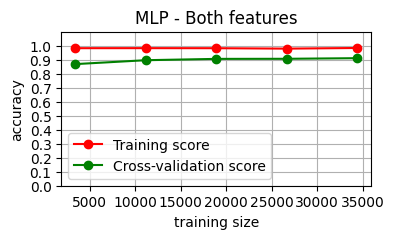

In [24]:
plot_learning_curve("MLP - Both features", mlp_all_estimator_base, X_train_all, y_train)

Accuracy:  0.924
Precision:  0.8932
Recall:  0.9234
F1 :  0.9064


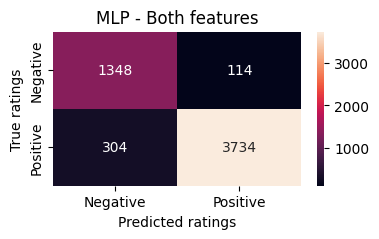

In [9]:
display_performance("MLP - Both features", mlp_all_pred_base, y_vad)

In [12]:
print("MLP Base - Both features")
mlp_both_base_pred_FP, mlp_both_base_pred_FN = getMismatch(mlp_all_pred_base, 10)

MLP Base - Both features
False Positive:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
39,33689,0.0,"Staff leaves a lot to be desired and if you have to deal with crap before you get to the a decent doctor, it ain't worth my time.",-1,1
61,33749,1.0,He advised me I needed a pace maker. Two weeks later his associate stated I did not need the pace maker. I had reservations about him from the moment I met him.,-1,1
169,33999,1.0,I have been seeing Dr. Fahrendorf for years. He always seems to help me with my back problems. He really is a great chiropractor,-1,1
184,34010,0.0,"I did not get the impression that Ms. Folkens has the empathy, knowledge, experience or skills to treat me or others well. I would not recommend her to my friends or family as a neurology provider. The office staff (ie nurses, receptionists) are, however, great.",-1,1
287,34162,1.0,Had to go to Sioux falls to get my arm repaired after Dr. Harbert did surgery,-1,1
327,34201,1.0,"My experience was not as well as these other seemingly happy people. Niiicccee doctor, nice",-1,1
406,34242,0.0,"She was very helpful and caring in the beginning of my diagnosis. By the time I started chemo she was very RUDE, UNCARING &amp; DISRESPECTFUL . She spent most of our office visits chewing me out. Her fill-in Dr treated me more then she did. This Dr was VERY Caring &amp; Concerned for me and has helped me the most during my breast cancer visits! I feel Dr. Krie overwhelmed me with kindness in the beginning so I would choose her n the facility to treat my Cancer. And I believed once Dr Krie felt I gained her trust, is when Krie's attitude twords me went negative! I thank God every day for Margret (fill-in Dr). She was the Greatest. I just wish Margret could finish my treatments. . .",-1,1
454,34302,1.0,"He hurt my back worse than it was already. He snapped my neck back in place, but he doesn't have an adjuster for ur actual spine, just seems to hope twisting ur legs a different way and putting weight on it will help. I have been to chiropractors before, I haven't seen one with as great a knowledge of anatomy and no practical way of applying it before in my life.... Don't go there.... U can get better care for free by having a friend step on ur back at home",-1,1
468,34324,0.0,"great ENT, needs to stick to ENT. Needs to stay away from allergy testing. Staff blew off delayed reaction to testing as insignificant. With immediate testing reaction did not give any direction on how to address allergy shown. lacked follow through on results and no referral to specialists to help me. went back to primary doctor and was referred to an allergy specialist. Ended up seeing another doctor to resolve issues with good success. Feel that I wasted my time and our insurance company's money with them.",-1,1
494,34388,2.0,Marginal at best A fair doctor willing to test to see whats wrong with you. To willing to push heavy duty drugs. I reccomend seeing someone else to avoid overmedication.,-1,1


False Negative:


,dr-id-adjusted,dr_id_gender,review-text-cleaned,rating,prediction
6,33636,0.0,"I had much better experience with Dr. Durant than a much more popular pediatric dentist in town. She was good, some of her office staff was new and didn't know some things, but was still helpful and didn't stop until she found the right answer.",1,-1
9,33643,2.0,,1,-1
17,33659,1.0,The absolute rudest front desk staff I have ever encountered. Once you get back to see the doctor it is fine but the office staff makes you really want to find another doctor.,1,-1
36,33678,1.0,"Doesn't have an on call Dr. number. I was in pain and just wanted to speak to a dentist that knew me, and let them know what was going on. I had to go to an urgent care to get antibiotics sbd pain meds that didn't work.",1,-1
57,33746,2.0,,1,-1
102,33871,1.0,"While I also believe that Dr. Allard is a wonderful doctor, I do not appreciate that I always have to call him for my lab results. (They have never called me with the results-I always seem to get forgotten). I would guess that this is because he has too large of a patient load. Each time I need to have him evaluate my lab results, I have to call the clinic in order to get the information needed. Not good customer service. :-(",1,-1
134,33896,0.0,"A. Front desk receptionist unknowledgable and flighty but they changed that. Sitting with sick child in room for an hour and forgot us. No communication between nurses, staff and patients. They made me feel like a bad mom because I chose to leave and take my child home after waiting an hour and a half.",1,-1
144,33923,1.0,,1,-1
150,33935,1.0,"Too many red flags went up when I saw him ,When my Dr was too busy.",1,-1
171,34004,0.0,"Dr. Angie is a great doctor. She really loves kids and it shows. The problem comes with the wait-time. It is ridiculous to sit in a waiting room for 1 hour and then to be called back to sit in another room for another hour only to see her for 10 minutes. It is rude and unacceptable. Yet, there is a 15 minute late rule, if the patient is late! My kids love going to see her, but I cannot afford to sit in a doctors office for 2 hours for an appointment that should only have 15 -20 minutes. As for the staff, I have never had any issues with the staff. They have always been able to answer my questions or accommodate my request. Now there is a fee to fill out school medical paperwork. what's next&#63; That was the straw that broke the camels back. We went to Patient First right down the street...walked in with no appointment, our first time visiting, saw the doctor, was given the medication and was out within 1 hour. This is what a doctor's office should be like.",1,-1
